## **Support Vector Machines**
Support Vector Machines (or simply SVM) method is a powerful and versatile set of algorithms for working with data of any form, used not only for classification and regression tasks, but also for detecting anomalies. In this tutorial we will discuss the main approaches to creating SVM, the principle of operation, as well as the implementations from scratch of its most popular varieties.

### **The linear SVM case**
**In the case of linear classification** the main idea of SVM is to find the hyperplane or line separating the classes in the best way, and the samples closest to the separating hyperplane are called *support vectors*. The best class separation would be one that maximizes the distance between the support vectors and the separating hyperplane. This distance is called the *margin*. There are 2 possible options here:
- 1) **Classification with a hard margin**, when all training samples must be correctly classified and located outside the separation band. This approach only works if the data is well linearly separable and is quite sensitive to outliers.
- 2) **Classification with a soft margin**, when the assumption is introduced that some training samples may violate the condition of correct classification or fall into the separation band, but at the same time a penalty for such violations is introduced, proportional to parameter C (the lower this value, the wider the band and more violations fall into the margin). With this approach, the generalizing ability of the model increases, which reduces the risk of overfitting.

The predicted classes will be a linear combination of weights and test features using the OVR (One-Versus-Rest) or OVA (One-Versus-All) strategy, and the hinge loss function is used to minimize:

$$min \rightarrow C \sum \limits_{i=1}^{n} max(0, 1 - y_i (w^TX + b))$$

In the implementation of scikit-learn, l1 or l2-regularization is also added to this loss function to choose from, and it is also possible to use the quadratic loss function using the loss='squared_hinge' parameter.

It is worth noting that problems with hard and soft margins are convex quadratic optimization problems with linear limits and relate to quadratic programming problems, for which there are many different ready-made packages.

In this case, a ready-made implementation based on the Liblinear library is used, but in the manual implementation below, gradient descent will be used for easier understanding with one improvement: the weights will not be updated at each iteration taking into account the predictions of all samples, but only taking into account the predictions for each training sample separately, provided that the margin size is less than 1, what is obtained from the equation above. This approach allows you to provide comparable accuracy of hinge loss without regularization with squared hinge loss with l2-regularization in scikit-learn, and if you use similar parameters, the accuracy will generally be slightly higher, but this solution is less stable.



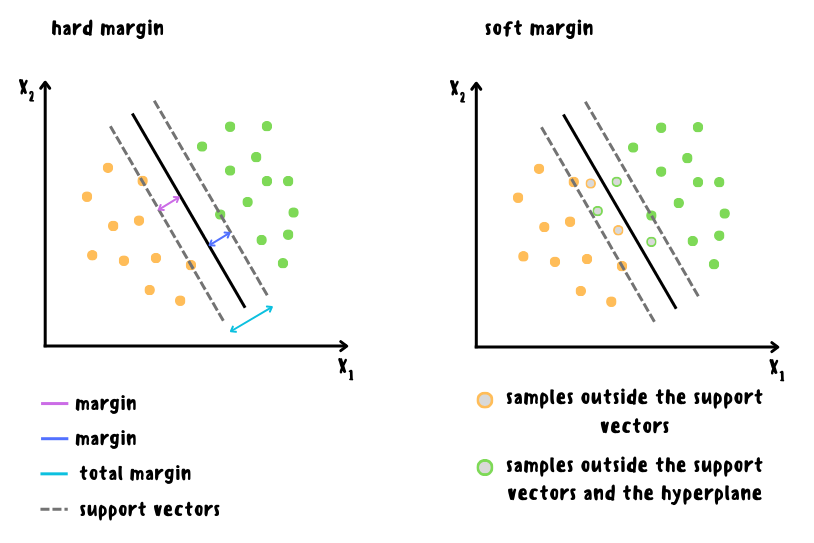

**In the case of linear regression** SVM tries to minimize the distance between the margin and the samples that lie outside it, and adding additional training samples inside the margin does not affect the final prediction. Simply put, the principle is the same as in usual linear regression, but instead of a line, a margin is used, the width of which is controlled by the epsilon parameter, and the minimized loss function is called epsilon-insensitive:

$$\min \rightarrow C \sum\limits_{i=1}^{n} \max(0, |y_i - (w^T \phi(x_i) + b)| - \varepsilon)$$

As in the case of classification, the scikit-learn implementation uses l1 or l2-regularization to choose from for SVM regression and the loss function can also be quadratic.

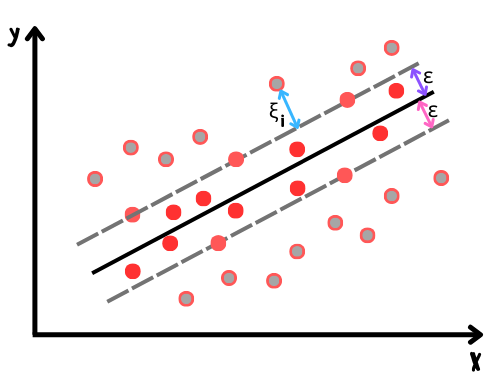

### **The non-linear SVM case**
**In the case of non-linear classification** the data is transformed into a higher dimensional space where they become linearly separable. One of the simplest ways is to add polynomial features, but in this case the computational complexity increases greatly.

A more interesting and effective way is to use the *kernel trick* — is a technique for working with data in the original space, in which the scalar product of transformed vectors of the n-th degree is replaced by their product in the power of n, which gives a similar result. Simply put, this approach allows you to get the same results as in the case of adding a large number of polynomial features without actually adding them.

$$\phi(a)^T \cdot \phi(b) = (a^T \cdot b)^n$$

$\phi \ - \ $ mapping function of degree n.

Below is an example of a kernel trick for a polynomial mapping of the second degree.

$$\phi(a)^T \cdot \phi(b) =
\left( \begin{array}{c} a_1^2 \\ \sqrt{2} a_1 a_2  \\ a_2^2 \end{array} \right)^T \cdot
\left( \begin{array}{c} b_1^2 \\ \sqrt{2} b_1 b_2  \\ b_2^2 \end{array} \right) =
a_1^2 b_1^2 + 2a_1 b_1 a_2 b_2 + a_2^2 b_2^2 = \\
= (a_1 b_1 + a_2 b_2)^2 =
\left( \begin{array}{c} \left( \begin{array}{c} a_1 \\ a_2 \end{array} \right)^T \cdot
\left( \begin{array}{c} b_1 \\ b_2 \end{array} \right) \end{array} \right)^2 = (a^T \cdot b)^2$$

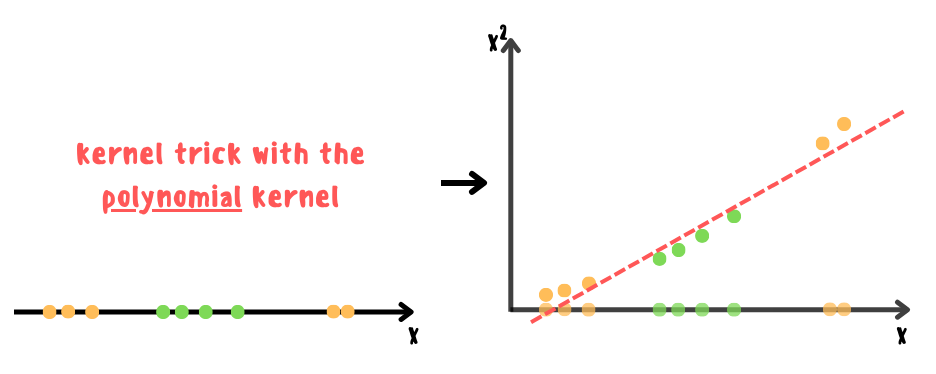

The function by which the kernel trick is performed, that is, the similarity between pairs of data points in the original space is determined, is called the kernel. The following kernels are supported in scikit-learn:

- linear — simply calculates the scalar product of vectors in the original space, which is equivalent to the usual linear classifier:

$$a^T \cdot b$$

- polynomial — is able to capture more complex dependencies between data, creating an optimal separating hyperplane in a new space, however, careful selection of parameters is required:

$$(\gamma a^T \cdot b + r)^d$$

- Gaussian RBF ([radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function)) is well suited for cases where the relation in the data has a complex non-linear shape and is less susceptible to overfitting, since it takes into account not only the values of the features, but also their distribution:

$$exp(-\gamma||a - b||^2)$$

- sigmoid — applies a hyperbolic tangent to a linear combination of vectors, simulating the use of a two-layer neural network with a sigmoid activation function, which also allows you to work well with complex non-linear cases, but this can lead to overfitting in case of noise and outliers:

$$tanh(\gamma a^t \cdot b + r)$$

It is also worth adding that the kernel trick can be applied not only in the context of SVM, but also to other algorithms. It just so happened historically that the kernel trick is associated with SVM.

**In the case of non-linear regression** SVM also tries to make the data linearly separable in a higher dimensional space, but only to find the optimal hyperplane that will minimize the distance between the maring and the samples as in the linear case.

Scikit-learn uses SVR and SVC classes based on the Libsvm library to work with non-linear cases, which implements an algorithm with support for the kernel trick and l2-regularization controlled by the C parameter.

### **Python implementation from scratch**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.utils import check_random_state, check_array
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR, _libsvm
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_diabetes

**Linear SVM**

In [ ]:
class LinearSVM:
    def __init__(self, regression=False, C=1.0, eps=0, learning_rate=0.001, max_iter=1000,
                 random_state=0):
        self.regression = regression
        self.C = C
        self.eps = eps
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y):
        if self.regression:
            self.bias, self.weights = self._find_weights(X, y)
        else:
            classes = np.unique(y)
            n_classes = len(classes)
            _, n_features = X.shape

            self.bias = np.zeros(n_classes)
            self.weights = np.zeros((n_classes, n_features))
            np.random.seed(self.random_state)

            for i, cls in enumerate(classes):
                y_binary = np.where(y == cls, 1, -1)
                self.bias[i], self.weights[i] = self._find_weights(X, y_binary)

    def _find_weights(self, X, y):
        n_samples, n_features = X.shape
        bias = 0
        weights = np.zeros(n_features) if self.regression else np.random.randn(n_features)

        for _ in range(self.max_iter):
            for i in range(n_samples):
                y_pred = X[i] @ weights + bias
                margin = y[i] - y_pred if self.regression else y[i] * y_pred
                condition = np.abs(margin) > self.eps if self.regression else margin < 1

                if condition:
                    if self.regression:
                        db = -self.C * (margin - self.eps)
                        dw = -self.C * (margin - self.eps) * X[i]
                    else:
                        db = -self.C * y[i]
                        dw = -self.C * y[i] * X[i]

                    bias -= self.learning_rate * db
                    weights -= self.learning_rate * dw

        return bias, weights

    def predict(self, X):
        scores = X @ self.weights.T + self.bias

        return scores if self.regression else np.argmax(scores, axis=1)

**Kernel SVM based on Libsvm**

In [ ]:
class SVM:
    def __init__(self, regression=False, C=1.0, kernel='rbf', degree=3, solver='auto',
                 gamma='scale', epsilon=0.1, coef0=0.0, shrinking=True, probability=False,
                 tol=0.001, cache_size=200, max_iter=-1, random_state=None):
        self.regression = regression
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.solver = solver
        self.gamma = gamma
        self.epsilon = epsilon
        self.coef0 = coef0
        self.shrinking = shrinking
        self.probability = probability
        self.tol = tol
        self.cache_size = cache_size
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X, y):
        X = X.astype(np.float64)
        y = y.astype(np.float64)

        rnd = check_random_state(self.random_state)
        seed = rnd.randint(np.iinfo('i').max)

        if self.gamma == 'scale':
            self.gamma = 1.0 / (X.shape[1] * X.var()) if X.var() != 0 else 1.0
        elif self.gamma == 'auto':
                self.gamma = 1.0 / X.shape[1]
        else:
            self.gamma = self.gamma

        if self.solver == 'auto':
            self.solver = 'epsilon_svr' if self.regression else 'c_svc'

        libsvm_impl = ['c_svc', 'nu_svc', 'one_class', 'epsilon_svr', 'nu_svr']
        self.solver = libsvm_impl.index(self.solver)

        (self.support_, self.support_vectors_, self._n_support, self.dual_coef_, self.intercept_,
         self._probA, self._probB, self.fit_status_, self._num_iter

        ) = _libsvm.fit(X, y, C=self.C, svm_type=self.solver, kernel=self.kernel, gamma=self.gamma,
                        degree=self.degree, epsilon=self.epsilon, coef0=self.coef0, tol=self.tol,
                        shrinking=self.shrinking, probability=self.probability,
                        cache_size=self.cache_size, max_iter=self.max_iter, random_seed=seed
                        )

    def predict(self, X_test):
        X_test = X_test.astype(np.float64)
        prediction = _libsvm.predict(X_test, self.support_, self.support_vectors_, self._n_support,
                                     self.dual_coef_, self.intercept_, self._probA, self._probB,
                                     svm_type=self.solver, kernel=self.kernel, degree=self.degree,
                                     coef0=self.coef0, gamma=self.gamma, cache_size=self.cache_size
                                     )

        return prediction if self.regression else prediction.astype(int)

**Visualization plots code**

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

### **Uploading datasets**
[Iris dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset) will be used to train models, where it is necessary to correctly determine the types of flowers based on their characteristics. In the case of regression, the load_linneryd dataset from scikit-learn is used.

In [ ]:
df_path = "/content/drive/MyDrive/iris.csv"
iris = pd.read_csv(df_path)
X1, y1 = iris.iloc[:, :-1], iris.iloc[:, -1]
y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values, y1.values, test_size=0.3, random_state=0)
print(iris)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


In [ ]:
X2, y2 = load_diabetes(return_X_y=True, as_frame=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2.values, y2.values, random_state=0)
print(X2, y2, sep='\n')

          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2    0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3   -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4    0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.041708  0.050680  0.019662  0.059744 -0.005697 -0.002566 -0.028674   
438 -0.005515  0.050680 -0.015906 -0.067642  0.049341  0.079165 -0.028674   
439  0.041708  0.050680 -0.015906  0.017293 -0.037344 -0.013840 -0.024993   
440 -0.045472 -0.044642  0.039062  0.001215  0.016318  0.015283 -0.028674   
441 -0.045472 -0.044642 -0.073030 -0.081413  0.083740  0.027809  0.173816   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1  

### **Models training and evaluation of the obtained results**
In the case of classification, SVC did a better job than LinearSVC, making the boundaries of class separation more flexible. As you can see, the decision boundaries of the SVC turned out to be flexible, since the linear decision boundary in the multidimensional feature space will correspond to a complex non-linear boundary in the original space.  

However, this approach does not always work better, as can be seen in the example of regression. Often, in data with a simple dependency, the linear kernel shows the best results.

**LinearSVC**

In [ ]:
linear_svc = LinearSVM(random_state=0)
linear_svc.fit(X1_train, y1_train)
linear_svc_pred_res = linear_svc.predict(X1_test)
linear_svc_accuracy = accuracy_score(y1_test, linear_svc_pred_res)

print(f'LinearSVC accuracy: {linear_svc_accuracy:}')
print(linear_svc_pred_res)

LinearSVC accuracy: 0.9333333333333333
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 2 0 0 2 0 0 1 1 0 2 2 0 2 2 1 0
 2 1 1 2 0 2 0 0]


**LinearSVC (scikit-learn)**

sk LinearSVC accuracy: 0.9333333333333333
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 2 0 0 2 0 0 1 1 0 2 2 0 2 2 1 0
 2 1 1 2 0 2 0 0]


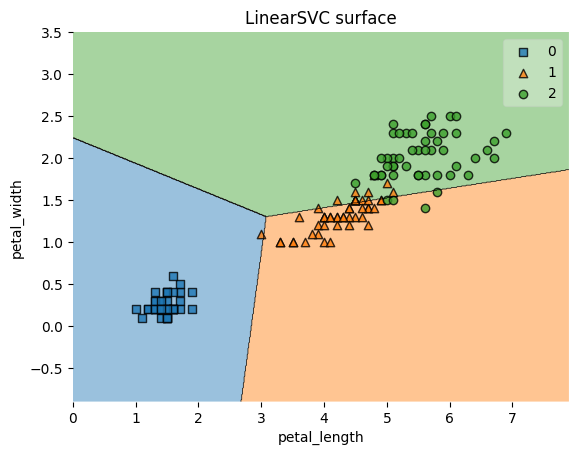

In [ ]:
sk_linear_svc = LinearSVC(loss='squared_hinge', max_iter=10000, random_state=0)
sk_linear_svc.fit(X1_train, y1_train)
sk_linear_svc_pred_res = sk_linear_svc.predict(X1_test)
sk_linear_svc_accuracy = accuracy_score(y1_test, sk_linear_svc_pred_res)

print(f'sk LinearSVC accuracy: {sk_linear_svc_accuracy:}')
print(sk_linear_svc_pred_res)

feature_indexes = [2, 3]
title1 = 'LinearSVC surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_linear_svc, feature_indexes, title1)

**SVC**

In [ ]:
svc = SVM(random_state=0, gamma='auto')
svc.fit(X1_train, y1_train)
svc_pred_res = svc.predict(X1_test)
svc_accuracy = accuracy_score(y1_test, svc_pred_res)

print(f'SVC accuracy: {svc_accuracy:}')
print(svc_pred_res)

SVC accuracy: 0.9777777777777777
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0]


**SVC (scikit-learn)**

sk SVC accuracy: 0.9777777777777777
[2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2 1 1 2 0 2 0 0]


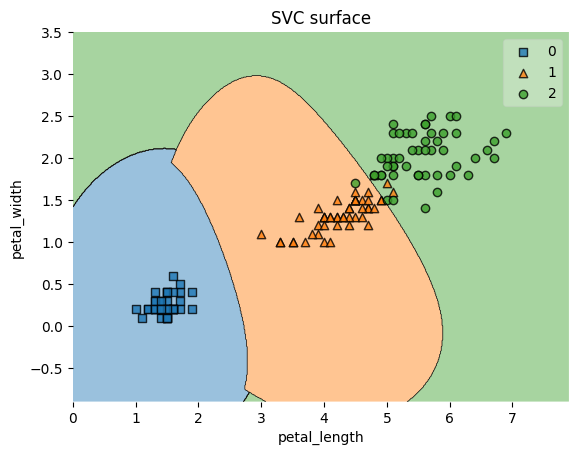

In [ ]:
sk_svc = SVC(random_state=0, gamma='auto')
sk_svc.fit(X1_train, y1_train)
sk_svc_pred_res = sk_svc.predict(X1_test)
sk_svc_accuracy = accuracy_score(y1_test, sk_svc_pred_res)

print(f'sk SVC accuracy: {sk_svc_accuracy:}')
print(sk_svc_pred_res)

feature_indexes = [2, 3]
title2 = 'SVC surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_svc, feature_indexes, title2)

**LinearSVR**

In [ ]:
linear_svr = LinearSVM(regression=True)
linear_svr.fit(X2_train, y2_train)
linear_svr_pred_res = linear_svr.predict(X2_test)
linear_svr_r2 = r2_score(y2_test, linear_svr_pred_res)

print(f'LinearSVR r2 score: {linear_svr_r2:}')
print(linear_svr_pred_res)

LinearSVR r2 score: 0.3792357370266678
[216.15968628 220.4481875  165.81989913 123.24660088 162.79339624
 219.32628582 114.40328867 187.29239041 135.60608051 192.94216428
 142.8356438  186.26887666 115.93676843  92.65131502 237.37770913
 105.70347983 140.17045763  78.03390184  93.19336622 213.55077346
 172.96582698 141.23351563 160.93321605 136.06861865 189.99746346
 162.00412166 119.88834206  95.16558303 169.4791898  167.9510029
 178.92773537  94.54901318 131.32930116 143.22717983 158.62314035
 179.63207827 161.26232493 184.99305841 137.0911429  190.80874425
  97.79122811 174.20746847 149.93081547 163.6511185  186.25250505
  89.10531469 134.71035596 137.85610675 143.47793077 213.7920584
 154.13931085  96.48578013 152.68919476 164.92850238 204.49516212
 184.36868908 186.98158124 104.04646649 155.49588864 175.27621381
 180.18811448 150.78618876 162.95426399 136.68414224 221.99330585
 141.62183394  91.8349318  225.76370605 194.54965172  69.11345544
  92.30405285 151.11667643 118.33817248

**LinearSVR (scikit-learn)**

In [ ]:
sk_linear_svr = LinearSVR(loss='squared_epsilon_insensitive')
sk_linear_svr.fit(X2_train, y2_train)
sk_linear_svr_pred_res = sk_linear_svr.predict(X2_test)
sk_linear_svr_r2 = r2_score(y2_test, sk_linear_svr_pred_res)

print(f'sk LinearSVR R2 score: {sk_linear_svr_r2:}')
print(sk_linear_svr_pred_res)

sk LinearSVR R2 score: 0.37814542044497423
[215.54802943 220.69479521 163.72321514 125.35050039 168.23663006
 222.87285934 117.76887939 183.439543   143.23792374 199.25861483
 149.2464745  180.13546176 117.73284104  98.8129158  229.40677283
 107.70075384 144.10708869  83.42833432 101.75722386 207.55264272
 177.38566123 146.60127268 159.10274119 144.47851976 188.12741871
 161.72800999 122.19555137  98.38934168 172.04469244 163.88747259
 174.31869231  98.56101933 137.43514957 143.99818253 152.57005935
 180.16575707 160.23942338 181.13802512 137.10299603 190.01855923
  99.30200726 168.53506831 147.88091211 166.46196854 180.1601789
  91.81189072 137.23909085 140.51020744 137.65220301 212.07954464
 154.84803714  97.88215713 154.47755522 160.16521948 206.99600783
 176.91673261 183.28777653 113.64466494 148.4110365  170.98296686
 185.33374519 155.94941503 161.03649538 131.05262642 225.54785872
 145.68037375  95.41892062 217.82197857 191.37652659  70.60017863
  96.29414312 144.83768093 117.209

**SVR**

In [ ]:
svr = SVM(regression=True)
svr.fit(X2_train, y2_train)
svr_pred_res = svr.predict(X2_test)
svc_r2 = r2_score(y2_test, svr_pred_res)

print(f'SVR r2 score: {svc_r2:}')
print(svr_pred_res)

SVR r2 score: 0.13842687260455933
[156.05494339 160.2561796  141.5352585  126.32530705 138.56287083
 157.79461531 118.30051225 153.1126463  133.32684359 151.34517091
 138.31021981 150.93156042 127.62035887 125.65861919 159.80948036
 119.27243753 132.8868118  115.3503535  130.26443966 154.69113982
 140.44764244 131.1864082  140.91091129 132.34658014 147.43835547
 141.71095095 135.93497953 120.372006   141.90918325 145.01581208
 147.05308508 115.34872572 128.98260578 139.39763958 141.37219221
 149.93533907 144.21593809 147.00705167 128.79733929 154.94745068
 122.27967665 145.73099063 138.72486465 142.87524309 149.4272714
 119.3023132  129.77336124 128.95425751 135.62538778 154.4679459
 137.44976849 114.591969   136.28102471 144.85720422 155.6502593
 145.13807371 149.33504099 124.03772077 141.352508   147.84699051
 148.25434815 133.39538615 143.03923607 131.48119845 154.73175072
 132.94449565 118.51262122 149.10562494 147.22897373 130.57831287
 116.89776562 139.90942034 125.511231   129.6

**SVR (scikit-learn)**

In [ ]:
sk_svr = SVR()
sk_svr.fit(X2_train, y2_train)
sk_svr_pred_res = sk_svr.predict(X2_test)
sk_svr_r2 = r2_score(y2_test, sk_svr_pred_res)

print(f'sk SVR r2 score: {sk_svr_r2:}')
print(sk_svr_pred_res)

sk SVR r2 score: 0.13842687260455933
[156.05494339 160.2561796  141.5352585  126.32530705 138.56287083
 157.79461531 118.30051225 153.1126463  133.32684359 151.34517091
 138.31021981 150.93156042 127.62035887 125.65861919 159.80948036
 119.27243753 132.8868118  115.3503535  130.26443966 154.69113982
 140.44764244 131.1864082  140.91091129 132.34658014 147.43835547
 141.71095095 135.93497953 120.372006   141.90918325 145.01581208
 147.05308508 115.34872572 128.98260578 139.39763958 141.37219221
 149.93533907 144.21593809 147.00705167 128.79733929 154.94745068
 122.27967665 145.73099063 138.72486465 142.87524309 149.4272714
 119.3023132  129.77336124 128.95425751 135.62538778 154.4679459
 137.44976849 114.591969   136.28102471 144.85720422 155.6502593
 145.13807371 149.33504099 124.03772077 141.352508   147.84699051
 148.25434815 133.39538615 143.03923607 131.48119845 154.73175072
 132.94449565 118.51262122 149.10562494 147.22897373 130.57831287
 116.89776562 139.90942034 125.511231   12

### **Pros and cons of the Support Vector Machines**

Pros:
- high accuracy of predictions;
- can be adapted to detect anomalies in the data;
- the ability to preprocess data without first converting or reducing the dimension.

Cons:
- low speed of operation on large data;
- due to the separation of data into hyperplanes, noise sensitivity or unstable operation with highly overlapping classes in the data may occur.

### **Additional sources**
Papers:
- «Statistical performance of Support Vector Machines», Gilles Blanchard, Olivier Bousquet and Pascal Massart;
- «A review of optimization methodologies in Support Vector Machines», John Shawe-Taylor, Shiliang Sun;
- «On the Algorithmic Implementation of Multiclass Kernel-based Vector Machines», Koby Crammer, Yoram Singer;
- «LIBLINEAR: A library for large linear classification», Rong-En Fan, Kai-Wei Chang, Cho-Jui Hsieh, Xiang-Rui Wang, Chih-Jen Lin;
- «LIBSVM: A Library for Support Vector Machines», Chih-Chung Chang and Chih-Jen Lin.

Documentation:
- [SVM methods description](https://scikit-learn.org/stable/modules/svm.html#);
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html);
- [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html);
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html);
- [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).

Video: [one](https://www.youtube.com/watch?v=_PwhiWxHK8o), [two](https://www.youtube.com/watch?v=V7mUNS3qXVY), [three](https://www.youtube.com/watch?v=0OLR3If-qS0), [four](https://www.youtube.com/watch?v=jMWjN6mJiSw), [five](https://www.youtube.com/watch?v=EESZtSOdhEQ), [six](https://www.youtube.com/watch?v=FrsIHCr4TZE), [seven](https://www.youtube.com/watch?v=efR1C6CvhmE), [eight](https://www.youtube.com/watch?v=Toet3EiSFcM), [nine](https://www.youtube.com/watch?v=Qc5IyLW_hns), [ten](https://www.youtube.com/watch?v=8xbnLHn4jjQ), [eleven](https://www.youtube.com/watch?v=rB-iRIpAPKo).
